In [7]:
import pandas as pd
import numpy as np
import copy
import warnings

warnings.filterwarnings("ignore")

In [8]:
np.random.seed(42)

In [9]:
data = pd.read_parquet('./data/mart/data_mart.parquet')

<h3>NA</h3>

In [10]:
data.isna().sum(axis=0).sum()

0

In [11]:
df = copy.deepcopy(data)

In [12]:
df.shape

(67648, 39)

<h3>Remove correlation</h3>

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.context('seaborn');

In [14]:
corr = df.corr(method='spearman')

In [15]:
# flag correlated items as True (except diagonal)
corr_mask = (abs(corr) > 0.85) * np.invert(np.eye(len(corr)).astype(bool))
# remove them
decorr_columns = corr[corr_mask].isna().all()
# get names
decorr_columns = decorr_columns[decorr_columns].index.values

In [16]:
df = df[decorr_columns]

In [17]:
corr = df.corr(method='spearman')
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,avg_item_profit,related products,office goods,breastfeeding products,"textile, knitwear",footwear,toys,women things,goods for pets,cosmetics and hygiene,diapers,avg_delivered
avg_item_profit,1.00,-0.00,-0.03,-0.12,0.15,0.09,-0.09,-0.03,-0.08,-0.21,-0.28,0.02
related products,-0.00,1.00,0.05,0.00,0.01,0.01,0.03,0.03,0.00,0.01,-0.01,-0.02
office goods,-0.03,0.05,1.00,-0.00,-0.03,0.00,0.01,0.03,0.00,0.01,-0.05,-0.02
breastfeeding products,-0.12,0.00,-0.00,1.00,-0.00,-0.07,-0.13,0.03,-0.00,0.24,0.08,-0.04
"textile, knitwear",0.15,0.01,-0.03,-0.00,1.00,0.04,-0.24,0.03,-0.02,-0.01,-0.14,-0.09
footwear,0.09,0.01,0.00,-0.07,0.04,1.00,-0.15,0.03,-0.01,-0.05,-0.11,-0.06
toys,-0.09,0.03,0.01,-0.13,-0.24,-0.15,1.00,-0.01,-0.06,-0.15,-0.27,0.02
women things,-0.03,0.03,0.03,0.03,0.03,0.03,-0.01,1.00,0.02,0.10,0.01,-0.02
goods for pets,-0.08,0.00,0.00,-0.00,-0.02,-0.01,-0.06,0.02,1.00,0.03,-0.02,-0.01
cosmetics and hygiene,-0.21,0.01,0.01,0.24,-0.01,-0.05,-0.15,0.10,0.03,1.00,0.18,-0.05


In [18]:
df.shape

(67648, 12)

<h3>Remove outliers</h3>

In [19]:
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor

In [20]:
%%time
outliers = IsolationForest(n_estimators=20, random_state=0).fit_predict(df.values)  # fit trees  
outliers = (outliers+1)//2

print('% of outliers with Isolation forest:', 1 - (np.sum(outliers) / df.shape[0]))

% of outliers with Isolation forest: 0.012978949858088895
CPU times: user 359 ms, sys: 43.4 ms, total: 403 ms
Wall time: 407 ms


In [21]:
df = df.loc[np.array(df.index)[outliers == 1]]

In [22]:
df.shape

(66770, 12)

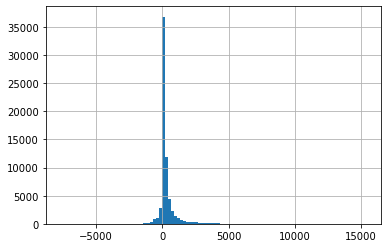

In [28]:
df['avg_item_profit'].hist(bins=100);

In [46]:
sign = (df['avg_item_profit'] > 0).astype(int)*2-1
df['avg_item_profit_log'] = (sign * np.log1p(np.abs(df['avg_item_profit'])))

In [48]:
df = df.drop('avg_item_profit', axis=1)

<h3>Normalize data</h3>

In [49]:
from sklearn import preprocessing

In [50]:
# define scaler
scaler = preprocessing.StandardScaler()
# normalize
X = scaler.fit_transform(df)

<h3>K-means</h3>

In [51]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MeanShift, MiniBatchKMeans, OPTICS

In [52]:
from scipy.spatial.distance import cdist

In [82]:
%%time
# k means determine k
distortions = []
K_range = range(1,12)
for k in K_range:
    kmeanModel = KMeans(n_clusters=k, max_iter=500, n_init=40, random_state=7).fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    
    print('{} / {}'.format(k,K[-1]))

1 / 11
2 / 11
3 / 11
4 / 11
5 / 11
6 / 11
7 / 11
8 / 11
9 / 11
10 / 11
11 / 11
CPU times: user 2min 15s, sys: 32.7 s, total: 2min 47s
Wall time: 22.1 s


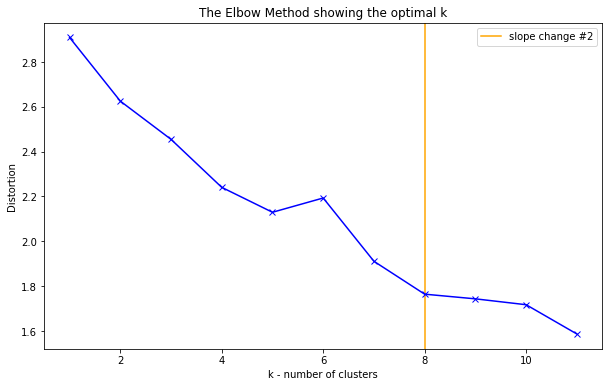

In [149]:
# Plot the elbow
plt.figure(figsize=(10,6))
#plt.axvline(6, 0, 1, label='slope change #1', color='red')
plt.axvline(8, 0, 1, label='slope change #2', color='orange')
plt.plot(K_range, distortions, 'bx-')
plt.xlabel('k - number of clusters')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.legend(); plt.show()

<h3>Visualize</h3>

In [84]:
from sklearn.decomposition import PCA, TruncatedSVD

In [85]:
Y_pca = PCA(n_components=2).fit_transform(X);
Y_svd = TruncatedSVD(n_components=2).fit_transform(X);

In [171]:
K = 8
kmeanModel = KMeans(n_clusters=K, max_iter=500, n_init=20, random_state=7).fit(X)

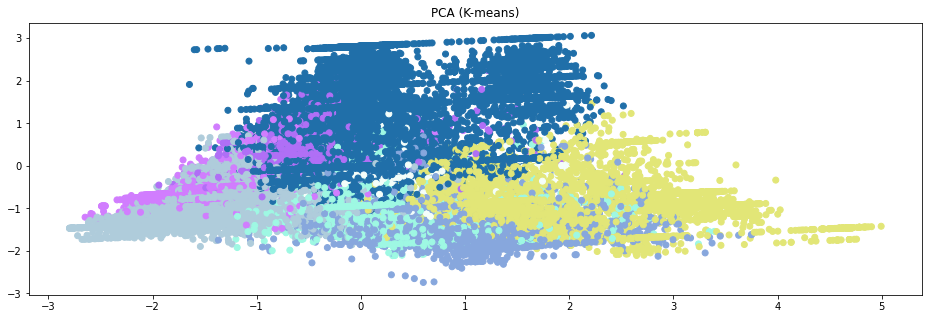

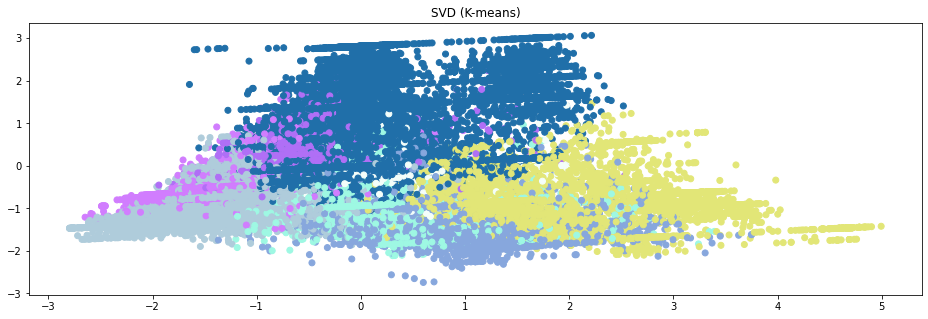

In [172]:
np.random.seed(21)
colors = np.sqrt(np.random.randint(0,255, size=(K, 3))/255)
c_arr = np.array(list(map(lambda x: colors[x], list(kmeanModel.labels_))))

plt.figure(figsize=(16,5)); plt.title('PCA (K-means)')
plt.scatter(Y_pca[:, 0], Y_pca[:, 1], c=c_arr);

plt.figure(figsize=(16,5)); plt.title('SVD (K-means)')
plt.scatter(Y_svd[:, 0], Y_svd[:, 1], c=c_arr);

In [173]:
labels, counts = np.unique(kmeanModel.labels_, return_counts=True)

In [174]:
cluster_sizes = pd.Series(data=counts, index=labels).sort_index(ascending=True)

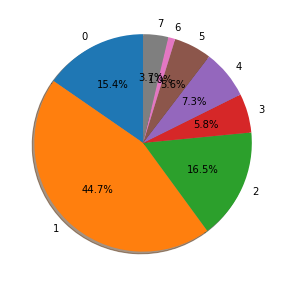

In [175]:
plt.figure(figsize=(16,5))
plt.pie(cluster_sizes, labels=cluster_sizes.index, autopct='%1.1f%%', shadow=True, startangle=90);

In [91]:
summary_stat = copy.deepcopy(df)
summary_stat['cluster'] = kmeanModel.labels_

In [92]:
stats = summary_stat.groupby('cluster').mean()#.T.plot.bar();
stats

,related products,office goods,breastfeeding products,"textile, knitwear",footwear,toys,women things,goods for pets,cosmetics and hygiene,diapers,avg_delivered,avg_item_profit_log
cluster,,,,,,,,,,,,
0,0.000071,0.002369,0.011474,0.012567,0.002320,0.021469,0.000062,0.001346,0.021631,0.500043,0.906300,1.634226
1,0.001930,0.005946,0.006077,0.013064,0.003498,0.400629,0.000113,0.000782,0.007204,0.012016,0.921152,4.163300
2,0.000321,0.003757,0.007560,0.583855,0.012373,0.025133,0.000270,0.000869,0.009722,0.012549,0.882559,5.257662
3,0.000205,0.003776,0.483563,0.028116,0.002307,0.031965,0.000095,0.000911,0.040664,0.044493,0.921442,4.245881
4,0.000218,0.004910,0.037119,0.030407,0.003004,0.029232,0.006463,0.002465,0.529420,0.076620,0.905786,3.697826
5,0.000121,0.002682,0.001419,0.042867,0.496056,0.019452,0.000025,0.000866,0.004088,0.007378,0.914513,5.283977
6,0.000159,0.002576,0.003666,0.006399,0.001853,0.015261,0.000106,0.667945,0.015338,0.010899,0.922025,2.987965
7,0.000261,0.532329,0.004744,0.017250,0.007407,0.076492,0.000037,0.001603,0.007142,0.012965,0.924420,4.827289


In [164]:
pd.DataFrame(pd.Series(kmeanModel.labels_, df.index, name='k_means')).to_parquet('./data/segments/kmeans.parquet')

<h3>DBSCAN</h3>

In [111]:
import math

In [112]:
%%time
X_sample = pd.DataFrame(X).sample(frac=0.10, random_state=42).values
eps, cluster_counts = [], []
for i in range(0,10):
    eps_p = 1.5 + 0.1*i
    dbscan = DBSCAN(eps=eps_p, algorithm='kd_tree', n_jobs=-1).fit(X_sample)
    n_clusters_ = len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)
    eps.append(eps_p); cluster_counts.append(n_clusters_)
    print('{} / {}'.format(i+1, 9))

1 / 9
2 / 9
3 / 9
4 / 9
5 / 9
6 / 9
7 / 9
8 / 9
9 / 9
10 / 9
CPU times: user 48.5 s, sys: 290 ms, total: 48.8 s
Wall time: 7.45 s


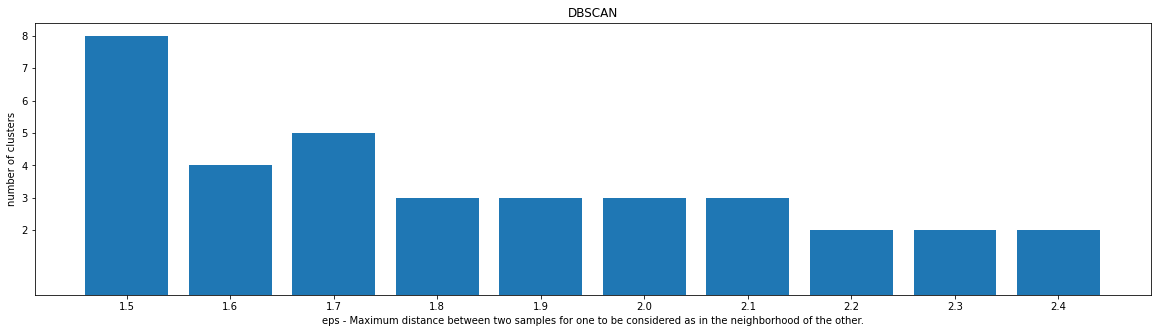

In [113]:
plt.figure(figsize=(20,5));
plt.yticks(range(min(cluster_counts), math.ceil(max(cluster_counts))+1));
plt.bar(np.round(np.array(eps), 2).astype(str), cluster_counts)
plt.xlabel('eps - Maximum distance between two samples for one to be considered as in the neighborhood of the other.')
plt.ylabel('number of clusters')
plt.title('DBSCAN');

<h3>T-SNE</h3>

In [114]:
from sklearn.manifold import TSNE

In [115]:
x_sample = np.random.choice(len(X), size=10000, replace=False)

In [116]:
%%time
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=600)
tsne_results = tsne.fit_transform(X[x_sample])

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.136s...
[t-SNE] Computed neighbors for 10000 samples in 1.827s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.026315
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.685234
[t-SNE] KL divergence after 600 iterations: 0.726294
CPU times: user 3min 52s,

In [117]:
sne_labels = kmeanModel.predict(X)[x_sample]

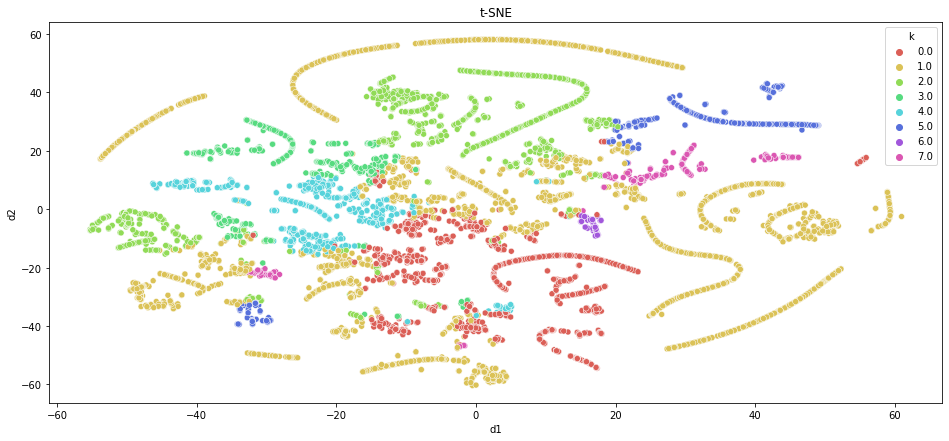

In [118]:
tSNE = pd.DataFrame(np.vstack((tsne_results.T, sne_labels)).T, columns=['d1', 'd2', 'k'])

plt.figure(figsize=(16,7)); plt.title('t-SNE')
sns.scatterplot(x='d1', y='d2', hue='k', data=tSNE, legend='full', alpha=1.,
                palette=sns.color_palette('hls', kmeanModel.n_clusters));

<h3>RFM</h3>

In [119]:
#Recency — number of days since the last purchase
#Frequency — number of transactions made over a given period
#Monetary — amount spent over a given period of time

In [120]:
ds = pd.read_parquet('./data/clean/all_positions.parquet')

In [121]:
ds = ds.rename(columns={'Телефон_new': 'phone'})

In [122]:
ds['ДатаДоставки'] = pd.to_datetime(ds['ДатаДоставки'], format='%m/%d/%Y')

In [123]:
ds = ds.sort_values(by='ДатаДоставки', ascending=False).groupby('phone').head(1)

In [124]:
most_recent = ds['ДатаДоставки'].max()

In [125]:
# Recency
ds['Recency'] = most_recent - ds['ДатаДоставки']

In [126]:
Recency = ds.set_index('phone')['Recency'].dropna()
Recency = Recency[Recency.index.isin(data.index)]
Recency

phone
55575056-49515452494870     0 days
55574956-52525654545279     2 days
55574948-52525657515579     4 days
55575050-49535356485779     6 days
55575056-50525655495477     6 days
                            ...   
55574953-50555249485273   148 days
55575054-51515051515272   148 days
55575054-53575554485579   148 days
55575053-48485251514879   148 days
55575054-50515655525172   148 days
Name: Recency, Length: 67648, dtype: timedelta64[ns]

In [127]:
recency = pd.DataFrame(Recency.dt.days)
frequency = data[['successful_orders_count']].rename(columns={'successful_orders_count': 'Frequency'})
monetary = data[['total_profit']].rename(columns={'total_profit': 'Monetary'})

In [128]:
assert recency.shape == frequency.shape == monetary.shape

In [129]:
RFM = pd.merge(pd.merge(recency, frequency, on='phone'), monetary, on='phone')

In [130]:
RFM

,Recency,Frequency,Monetary
phone,,,
55575056-49515452494870,0,5,2334.79
55574956-52525654545279,2,1,175.60
55574948-52525657515579,4,2,152.63
55575050-49535356485779,6,1,78.43
55575056-50525655495477,6,1,2497.31
...,...,...,...
55574953-50555249485273,148,1,558.00
55575054-51515051515272,148,1,6.72
55575054-53575554485579,148,1,403.52


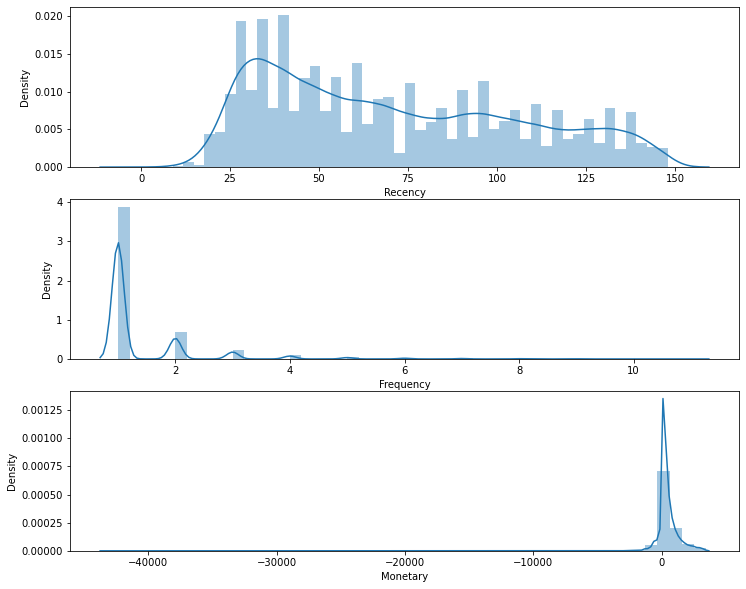

In [131]:
# Plot RFM distributions
plt.figure(figsize=(12,10))
# Plot distribution of R
plt.subplot(3, 1, 1); sns.distplot(RFM['Recency'])
# Plot distribution of F
plt.subplot(3, 1, 2); sns.distplot(RFM['Frequency'][RFM['Frequency'] < RFM['Frequency'].quantile(0.999)])
# Plot distribution of M
plt.subplot(3, 1, 3); sns.distplot(RFM['Monetary'][RFM['Monetary'] < RFM['Monetary'].quantile(0.97)])
# Show the plot
plt.show()

In [132]:
# --Calculate R and F groups--
# Create labels for Recency and Frequency
r_labels = range(4, 0, -1); f_labels = range(1, 4)
# Assign these labels to 4 equal percentile groups 
r_groups = pd.qcut(RFM['Recency'], q=4, labels=r_labels)
# Assign these labels to 4 equal percentile groups 
f_groups = pd.qcut(RFM['Frequency'], q=20, labels=f_labels, duplicates='drop')
# Create new columns R and F 
RFM = RFM.assign(R = r_groups.values, F = f_groups.values)
RFM.head()

,Recency,Frequency,Monetary,R,F
phone,,,,,
55575056-49515452494870,0,5,2334.79,4,3
55574956-52525654545279,2,1,175.60,4,1
55574948-52525657515579,4,2,152.63,4,1
55575050-49535356485779,6,1,78.43,4,1
55575056-50525655495477,6,1,2497.31,4,1


In [133]:
# Create labels for MonetaryValue
m_labels = range(1, 5)
# Assign these labels to three equal percentile groups 
m_groups = pd.qcut(RFM['Monetary'], q=4, labels=m_labels)
# Create new column M
RFM = RFM.assign(M = m_groups.values)

In [134]:
RFM

,Recency,Frequency,Monetary,R,F,M
phone,,,,,,
55575056-49515452494870,0,5,2334.79,4,3,4
55574956-52525654545279,2,1,175.60,4,1,2
55574948-52525657515579,4,2,152.63,4,1,2
55575050-49535356485779,6,1,78.43,4,1,1
55575056-50525655495477,6,1,2497.31,4,1,4
...,...,...,...,...,...,...
55574953-50555249485273,148,1,558.00,1,1,3
55575054-51515051515272,148,1,6.72,1,1,1
55575054-53575554485579,148,1,403.52,1,1,3


In [135]:
%%time
# Concat RFM quartile values to create RFM Segments
def join_rfm(x): 
    return str(int(x['R'])) + str(int(x['F'])) + str(int(x['M']))

RFM['RFM_Segment_Concat'] = RFM.apply(join_rfm, axis=1)
rfm = RFM
rfm.head()

CPU times: user 848 ms, sys: 7.82 ms, total: 856 ms
Wall time: 856 ms


,Recency,Frequency,Monetary,R,F,M,RFM_Segment_Concat
phone,,,,,,,
55575056-49515452494870,0,5,2334.79,4,3,4,434
55574956-52525654545279,2,1,175.60,4,1,2,412
55574948-52525657515579,4,2,152.63,4,1,2,412
55575050-49535356485779,6,1,78.43,4,1,1,411
55575056-50525655495477,6,1,2497.31,4,1,4,414


In [136]:
# Count num of unique segments
rfm_count_unique = rfm.groupby('RFM_Segment_Concat')['RFM_Segment_Concat'].nunique()
print('Number of unique segmens:', rfm_count_unique.sum())

Number of unique segmens: 48


<h3>Summing the score</h3>

In [137]:
# Calculate RFM_Score
rfm['RFM_Score'] = rfm[['R','F','M']].sum(axis=1)
print(rfm['RFM_Score'].head())

phone
55575056-49515452494870    11
55574956-52525654545279     7
55574948-52525657515579     7
55575050-49535356485779     6
55575056-50525655495477     9
Name: RFM_Score, dtype: int64


In [138]:
# Define rfm_level function
def rfm_level(df):
    if df['RFM_Score'] >= 9:
        return 'Can\'t Loose Them'
    elif ((df['RFM_Score'] >= 8) and (df['RFM_Score'] < 9)):
        return 'Champions'
    elif ((df['RFM_Score'] >= 7) and (df['RFM_Score'] < 8)):
        return 'Loyal'
    elif ((df['RFM_Score'] >= 6) and (df['RFM_Score'] < 7)):
        return 'Potential'
    elif ((df['RFM_Score'] >= 5) and (df['RFM_Score'] < 6)):
        return 'Sleeping' # Primising
    elif ((df['RFM_Score'] >= 4) and (df['RFM_Score'] < 5)):
        return 'Needs Attention'
    else:
        return 'Require Activation'
# Create a new variable RFM_Level
rfm['RFM_Level'] = rfm.apply(rfm_level, axis=1)
# Print the header with top 5 rows to the console
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment_Concat,RFM_Score,RFM_Level
phone,,,,,,,,,
55575056-49515452494870,0,5,2334.79,4,3,4,434,11,Can't Loose Them
55574956-52525654545279,2,1,175.60,4,1,2,412,7,Loyal
55574948-52525657515579,4,2,152.63,4,1,2,412,7,Loyal
55575050-49535356485779,6,1,78.43,4,1,1,411,6,Potential
55575056-50525655495477,6,1,2497.31,4,1,4,414,9,Can't Loose Them


<h3>RFM results</h3>

In [139]:
import squarify

In [140]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_level_agg = rfm.groupby('RFM_Level').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(1)
# Print the aggregated dataset
print(rfm_level_agg.loc[["Can't Loose Them", "Champions", "Loyal", "Potential", "Sleeping", "Require Activation"]])

                   Recency Frequency Monetary       
                      mean      mean     mean  count
RFM_Level                                           
Can't Loose Them      33.9       3.0   1933.9   7642
Champions             42.7       1.5   1120.6   7804
Loyal                 54.3       1.3    758.7  11220
Potential             68.7       1.2    495.2  15284
Sleeping              86.5       1.1    182.1  12061
Require Activation   120.0       1.0   -138.0   4274


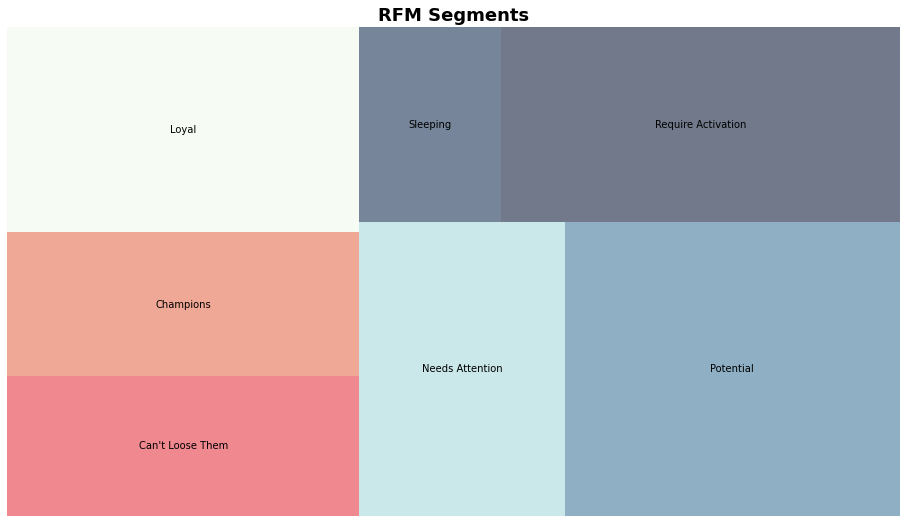

In [141]:
rfm_level_agg.columns = rfm_level_agg.columns.droplevel()
rfm_level_agg.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 9)
squarify.plot(sizes=rfm_level_agg['Count'], 
              label=['Can\'t Loose Them',
                     'Champions',
                     'Loyal',
                     'Needs Attention',
                     'Potential', 
                     'Sleeping', 
                     'Require Activation'],
              color=['#e63946',
                     '#e76f51',
                     '#f1faee',
                     '#a8dadc',
                     '#457b9d',
                     '#1d3557',
                     '#14213d'],
              alpha=.6,)
plt.title("RFM Segments",fontsize=18,fontweight="bold")
plt.axis('off')
plt.show()

<h3>Save RFM</h3>

In [142]:
from pathlib import Path

In [143]:
Path("./data/rfm").mkdir(parents=True, exist_ok=True)

In [144]:
rfm.to_parquet('./data/segments/rfm.parquet')